In [35]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import json
#from scipy import stats
#import scipy.interpolate as interp
from pprint import pprint
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14

In [36]:
import FEMmodule as FEM

# Toy FEM - python version

This code is the Python replica of the matlab code used in *LAB01* of the course **Nonlinear Analysis of Aerospace Structures** held by Marco Morandini, Riccardo Vescovini at *Politecnico di Milano*

## Build matrices

- *nodes* matrix: containing nodes coordinates
- *elements* matrix: connectivity matrix associating nodes to elements
- *constrained elements* vector: list of constrained (fixed) nodes

Parameters are **nx** and **ny**: number of elements in *x* and *y* directions.

Default plate size is l=10, w=2. It can be changes passing additional parameters to **Nodes**

In [37]:
nx = ny = 8
#ny = 2
l = 10.
w = 2.

In [38]:
nodes, elements, constr_nodes = FEM.Nodes(nx,ny)
#nodes, elements, constr_nodes = FEM.Nodes(nx,ny, l, w)

Create a Gaussian integrator for **2D** 2$\times$2 matrix

In [39]:
GI = FEM.GaussIntegr2D2x2()

Create a *plane stress* **Elastic Tensor** with parameters **E** and **$\nu$**

In [40]:
E = FEM.PlaneStressElasticTensor(1.e4, 0.3)

Create a set of *bilinear weights*, used to interppolate a **2D** function on a $(x,y)$ grid

In [41]:
W = FEM.BilinearWeights()

Build vectors of *constrained* and *free* **DOFs**

In [42]:
constr_dofs = np.append(constr_nodes, constr_nodes + nodes.shape[0])
free_dofs = np.array([i for i in range(0,2*nodes.shape[0]) if i not in constr_dofs])

Build matrices

In [43]:
ne = nodes.shape[0]*nodes.shape[1]
GlobalStiff = np.zeros((ne,ne))
GlobalRes = np.zeros(ne)
GlobalDispl = np.zeros_like(GlobalRes)

**Force** vector: $[F_x , F_y]$

In [44]:
force = np.array([0. ,1.])

## Compute

Compute *global stiffness matrix* and *global resultants*:

In [45]:
for e in range(elements.shape[0]):
    act_e = elements[e,:].astype(int)
    #print "act element: ",act_e
    Stiff = GI.Integrate(lambda x : FEM.ElementLocalStiffness(nodes[act_e,:], E, W, x) )
    #print "stiffness: ",Stiff
    Res = GI.Integrate(lambda x : FEM.ElementVolumeForce(nodes[act_e,:], force, W, x) )
    conn = np.concatenate((act_e, act_e + nodes.shape[0]))
    indxs = np.ix_(conn,conn)
    GlobalStiff[indxs] = GlobalStiff[indxs] + Stiff
    GlobalRes[conn] = GlobalRes[conn] + Res

Remove *dofs* that are constrained

In [46]:
mask = np.ones(GlobalStiff.shape[0], dtype=bool)
mask[constr_dofs] = False

#pprint(GlobalStiff)
#print GlobalRes

indxs = np.ix_(mask,mask)
GlobalStiff = GlobalStiff[indxs]
GlobalRes = GlobalRes[mask]

compute node displacements

In [47]:
displ = np.linalg.solve(GlobalStiff, GlobalRes)

In [48]:
GlobalDispl[free_dofs] = displ

In [49]:
GlobalDispl = GlobalDispl.reshape(nodes.shape,order='F')

In [50]:
def plotMesh(nodes, elements, style=None):
    c = np.array([[0,1],[1,2],[2,3],[3,0]])
    for e in range(elements.shape[0]):
        el = elements[e,:].astype(int)
        for l in range(len(c)):
            plt.plot(nodes[el[c[l,:]],0],nodes[el[c[l,:]],1],style)

## Plot mesh and results

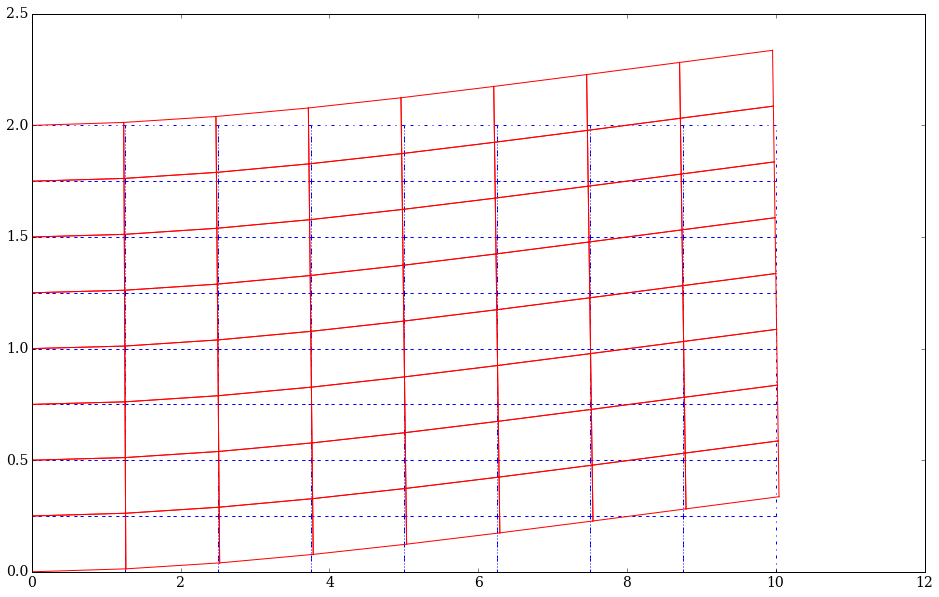

In [51]:
plt.figure(figsize=(16,10), dpi=300)
plotMesh(nodes,elements,'b-.')
plotMesh(nodes+GlobalDispl,elements,'r')

## Compute $\sigma_{xx}$ at center of first element

Compute strains from displacements $\epsilon = \mathbf{B}\cdot u$:

In [52]:
u0 = np.array([GlobalDispl[i,0] for j in range(2) for i in elements[0,:]])

In [53]:
der,J = FEM.SpatialDerivative(nodes[elements[0,:].astype(int)],np.zeros(2),W.Ders)
eps = np.dot(FEM.BN(der),u0)

Compute stresses from strains: $\sigma = \mathbf{E} \cdot \epsilon$:

In [54]:
sigma = np.dot(E.ElTens, eps)

$\sigma_{xx}$ = 

In [55]:
print "%.3f" % sigma[0]

81.337


## Compute tip displacement at half beam width

In [56]:
tip = GlobalDispl[(nx+1)*((ny+1)//2+1)-1,1]
print "%.4f" % tip

0.3364


### Alternative derivation of strain vector

Computation of general derivative of *bilinear* relation has been carried on in this [file](./pyToyFEMderiv.ipynb)

Compute length and width of cell: lc wc

In [57]:
lc = l/nx
wc = w/ny

Relation between *node displacements* and *strains*:

$$
\begin{align}
\epsilon_{xx} & = \frac{\partial u_{x}}{\partial x} \\
\epsilon_{yy} & = \frac{\partial u_{y}}{\partial y} \\
2 \cdot \epsilon_{xy} & = \frac{\partial u_{x}}{\partial y} + \frac{\partial u_{y}}{\partial x}
\end{align}
$$

which, in case of bilinear shape of displacements within the cell, given the node displacements becomes:

$$
\begin{align}
\mathbf{\epsilon} & = \mathbf{B} \cdot \mathbf{u}
\end{align}
$$

with:

$$
\begin{equation*}
\mathbf{B} =  \frac{1}{2} \cdot
\begin{bmatrix}
-\frac{1}{l_c} & \frac{1}{l_c} & \frac{1}{l_c} & -\frac{1}{l_c} & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 &  -\frac{1}{w_c} & -\frac{1}{w_c} & \frac{1}{w_c} & \frac{1}{w_c}\\
-\frac{1}{w_c} & -\frac{1}{w_c} & \frac{1}{w_c} & \frac{1}{w_c} & -\frac{1}{l_c} & \frac{1}{l_c} & \frac{1}{l_c} & -\frac{1}{l_c}
\end{bmatrix}  
\end{equation*}
$$


In [58]:
B1 = 0.5*np.array([[-1/lc, 1/lc, 1/lc, -1/lc, 0., 0., 0., 0.],\
                   [0., 0., 0., 0., -1/wc, -1/wc, 1/wc, 1/wc],
                   [-1/wc, -1/wc, 1/wc, 1/wc, -1/lc, 1/lc, 1/lc, -1/lc]])

In [59]:
sigma1 = E.ElTens.dot(B1.dot(u0))
print "%.3f" % sigma1[0]

81.337


which gives the same result as above

# Effect of mesh size

To analyze the effect of mesh size we compute tip displacement at half width of the bar and $\sigma_{xx}$ at center of first element (connected to ground)

## Case 1: equal number of elements in *x* and *y* directions

In [60]:
ne_v = np.logspace(1,6,num=6,base=2)
tip_displ = np.zeros_like(ne_v)
sigma_xx = np.zeros_like(ne_v)
ne_v

array([  2.,   4.,   8.,  16.,  32.,  64.])

In [61]:
for ii, nx in enumerate(ne_v):
    print "step ",ii," nx = ",nx
    nodes, elements, constr_nodes = FEM.Nodes(nx,nx)
    
    constr_dofs = np.append(constr_nodes.astype(int), constr_nodes.astype(int) + nodes.shape[0])
    free_dofs = np.array([i for i in range(0,2*nodes.shape[0]) if i not in constr_dofs])
    
    ne = nodes.shape[0]*nodes.shape[1]
    GlobalStiff = np.zeros((ne,ne))
    GlobalRes = np.zeros(ne)
    GlobalDispl = np.zeros_like(GlobalRes)
    
    for e in range(elements.shape[0]):
        act_e = elements[e,:].astype(int)

        Stiff = GI.Integrate(lambda x : FEM.ElementLocalStiffness(nodes[act_e,:], E, W, x) )
        
        Res = GI.Integrate(lambda x : FEM.ElementVolumeForce(nodes[act_e,:], force, W, x) )
        conn = np.concatenate((act_e, act_e + nodes.shape[0]))
        indxs = np.ix_(conn,conn)
        GlobalStiff[indxs] = GlobalStiff[indxs] + Stiff
        GlobalRes[conn] = GlobalRes[conn] + Res
        
    mask = np.ones(GlobalStiff.shape[0], dtype=bool)
    mask[constr_dofs] = False
    
    indxs = np.ix_(mask,mask)
    GlobalStiff = GlobalStiff[indxs]
    GlobalRes = GlobalRes[mask]
    
    displ = np.linalg.solve(GlobalStiff, GlobalRes)
    GlobalDispl[free_dofs] = displ
    GlobalDispl = GlobalDispl.reshape(nodes.shape,order='F')
    
    tip_displ[ii] = GlobalDispl[(nx+1)*((nx+1)//2+1)-1,1]
    
    u0 = np.array([GlobalDispl[i,j] for j in range(2) for i in elements[0,:]])
    
    der,J = FEM.SpatialDerivative(nodes[elements[0,:].astype(int)],np.zeros(2),W.Ders)
    eps = np.dot(FEM.BN(der),u0)
    
    sigma = np.dot(E.ElTens, eps)
    
    sigma_xx[ii] = sigma[0]

step  0  nx =  2.0
step  1  nx =  4.0
step  2  nx =  8.0
step  3  nx =  16.0
step  4  nx =  32.0
step  5  nx =  64.0


In [62]:
sigma_xx

array([  14.22520869,   55.50280029,  102.41724147,  133.40908686,
        154.64481725,  175.27541217])

In [63]:
tip_displ

array([ 0.12138038,  0.2436252 ,  0.33639804,  0.37357914,  0.38465247,
        0.38767365])

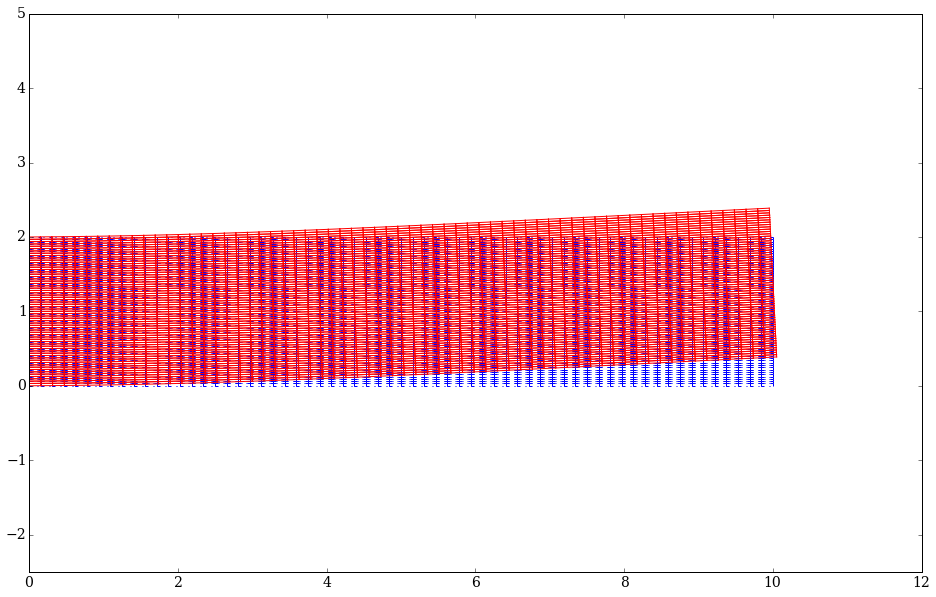

In [64]:
plt.figure(figsize=(16,10), dpi=300)
plotMesh(nodes,elements,'b-.')
plotMesh(nodes+GlobalDispl,elements,'r')
plt.axis('equal');

## Case 2: square elements

In [65]:
ne_v = np.logspace(0,5,num=6,base=2)
tip_displ = np.zeros_like(ne_v)
sigma_xx = np.zeros_like(ne_v)
print ne_v

[  1.   2.   4.   8.  16.  32.]


In [66]:
for ii, nx in enumerate(ne_v):
    print "step ",ii," nx = ",nx
    nodes, elements, constr_nodes = FEM.Nodes(5*nx,nx)
    
    constr_dofs = np.append(constr_nodes.astype(int), constr_nodes.astype(int) + nodes.shape[0])
    free_dofs = np.array([i for i in range(0,2*nodes.shape[0]) if i not in constr_dofs])
    
    ne = nodes.shape[0]*nodes.shape[1]
    GlobalStiff = np.zeros((ne,ne))
    GlobalRes = np.zeros(ne)
    GlobalDispl = np.zeros_like(GlobalRes)
    
    for e in range(elements.shape[0]):
        act_e = elements[e,:].astype(int)

        Stiff = GI.Integrate(lambda x : FEM.ElementLocalStiffness(nodes[act_e,:], E, W, x) )
        
        Res = GI.Integrate(lambda x : FEM.ElementVolumeForce(nodes[act_e,:], force, W, x) )
        conn = np.concatenate((act_e, act_e + nodes.shape[0]))
        indxs = np.ix_(conn,conn)
        GlobalStiff[indxs] = GlobalStiff[indxs] + Stiff
        GlobalRes[conn] = GlobalRes[conn] + Res
        
    mask = np.ones(GlobalStiff.shape[0], dtype=bool)
    mask[constr_dofs] = False
    
    indxs = np.ix_(mask,mask)
    GlobalStiff = GlobalStiff[indxs]
    GlobalRes = GlobalRes[mask]
    
    displ = np.linalg.solve(GlobalStiff, GlobalRes)
    GlobalDispl[free_dofs] = displ
    GlobalDispl = GlobalDispl.reshape(nodes.shape,order='F')
    
    tip_displ[ii] = GlobalDispl[(5*nx+1)*((nx+1)//2+1)-1,1]
    
    u0 = np.array([GlobalDispl[i,j] for j in range(2) for i in elements[0,:]])
    
    der,J = FEM.SpatialDerivative(nodes[elements[0,:].astype(int)],np.zeros(2),W.Ders)
    eps = np.dot(FEM.BN(der),u0)
    
    sigma = np.dot(E.ElTens, eps)
    
    sigma_xx[ii] = sigma[0]

step  0  nx =  1.0
step  1  nx =  2.0
step  2  nx =  4.0
step  3  nx =  8.0
step  4  nx =  16.0
step  5  nx =  32.0


In [67]:
sigma_xx

array([  1.87769519e-13,   6.13926613e+01,   1.04742387e+02,
         1.33781918e+02,   1.57223530e+02,   1.81289501e+02])

In [68]:
tip_displ

array([ 0.26577778,  0.34487229,  0.37601366,  0.38526156,  0.38781202,
        0.38851589])

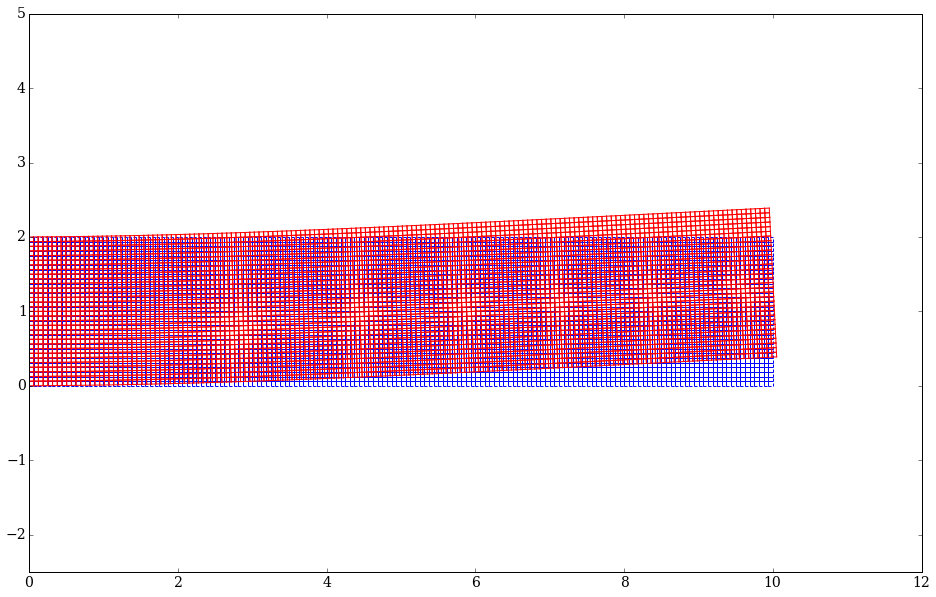

In [69]:
plt.figure(figsize=(16,10), dpi=300)
plotMesh(nodes,elements,'b-.')
plotMesh(nodes+GlobalDispl,elements,'r')
plt.axis('equal');